In [1]:
import re
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def parse_output(output):
    valid_matches = []
    depth = 0
    current_segment = ""
    inside_brackets = False
    
    for char in output:
        if char == '[':
            if depth > 0:
                # If already inside brackets, append this '[' to current_segment
                current_segment += char
            depth += 1
            inside_brackets = True
        elif char == ']':
            depth -= 1
            if depth == 0:
                # When depth returns to 0, we have a complete bracketed segment
                if inside_brackets:
                    parts = [part.strip() for part in current_segment.split('|')]
                    if len(parts) >= 2:
                        result = (parts[0], parts[1])
                        if len(parts) > 2:
                            result = (parts[0], parts[1])
                        valid_matches.append(result)
                    current_segment = ""
                    inside_brackets = False
            else:
                # If still inside brackets, append this ']' to current_segment
                current_segment += char
        else:
            if inside_brackets:
                current_segment += char
    
    return valid_matches


def normalize_segment(segment):
    if segment is None:
        return ""
    return segment.strip().lower()


In [3]:
def count_true_classifications(true_outputs):
    total_classifications = 0
    
    for output in true_outputs:
        valid_matches = parse_output(output)
        total_classifications += len(valid_matches)

    return total_classifications

def count_true_output_paragraphs(true_outputs):
    return len(true_outputs)

In [4]:
def compare_outputs(true_output, predicted_output):
    true_matches = parse_output(true_output)
    predicted_matches = parse_output(predicted_output)

    true_set = set(true_matches)
    pred_set = set(predicted_matches)

    # Extract parts and check exact matches based on parts
    true_parts_set = {normalize_segment(match[0]) for match in true_set}
    pred_parts_set = {normalize_segment(match[0]) for match in pred_set}

    # Find exact part matches
    exact_matches_parts = true_parts_set.intersection(pred_parts_set)

    # Filter out exact matches from original sets (true_set and pred_set)
    true_set_filtered = {match for match in true_set if normalize_segment(match[0]) not in exact_matches_parts}
    pred_set_filtered = {match for match in pred_set if normalize_segment(match[0]) not in exact_matches_parts}

    # Initialize bracket mismatch lists
    bracket_mismatches_longer = []
    bracket_mismatches_shorter = []

    # Number of exact matches
    true_pred_output = len(exact_matches_parts)

    # Compare remaining parts
    for true_part in true_set_filtered:
        for pred_part in pred_set_filtered:
            true_part_text = normalize_segment(true_part[0])
            pred_part_text = normalize_segment(pred_part[0])
            if true_part_text in pred_part_text:
                bracket_mismatches_longer.append((true_part, pred_part))
            elif pred_part_text in true_part_text:
                bracket_mismatches_shorter.append((true_part, pred_part))

    return true_pred_output, bracket_mismatches_longer, bracket_mismatches_shorter

In [5]:
def save_errors_to_files(bracket_mismatches_longer, bracket_mismatches_shorter):
    base_dir = "errors"

    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    with open(os.path.join(base_dir, "boundary_mismatches.txt"), 'a') as f:
        for true_case, pred_case in bracket_mismatches_longer:
            f.write(f"True: {true_case}, Predicted: {pred_case}\n")
    with open(os.path.join(base_dir, "boundary_mismatches.txt"), 'a') as f:
        for true_case, pred_case in bracket_mismatches_shorter:
            f.write(f"True: {true_case}, Predicted: {pred_case}\n")

In [6]:
import matplotlib.cm as cm

def count_and_plot_errors(bracket_mismatches_longer, bracket_mismatches_shorter, true_outputs):
    error_counts = {
        'Boundary Mismatches \n (Longer)': len(bracket_mismatches_longer),
        'Boundary Mismatches \n (Shorter)': len(bracket_mismatches_shorter),
    }

    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)
    error_types, counts = zip(*sorted_errors) if sorted_errors else ([], [])

    total_classifications = count_true_classifications(true_outputs)

    percentages = []

    for error_type, count in zip(error_types, counts):
        percentage = (count / total_classifications) * 100
        percentages.append(percentage)


    sorted_percentages = [percentage for _, percentage in sorted(zip(error_types, percentages), key=lambda x: x[1], reverse=True)]
    sorted_error_types = sorted(error_types, key=lambda x: percentages[error_types.index(x)], reverse=True)

    colors = cm.Blues(np.linspace(1, 0.4, len(sorted_error_types)))
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_error_types, sorted_percentages, color=colors, edgecolor='black')

    max_percentage = max(sorted_percentages)
    padding = 10  # Adjust padding as needed

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.75, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center', ha='left', fontsize=20)

    plt.xlabel('Percentage of Total Errors', fontsize=18)
    plt.yticks(fontsize=16)
    plt.gca().invert_yaxis()
    plt.xlim(0, max_percentage + padding)
    plt.tight_layout()
    plt.show()

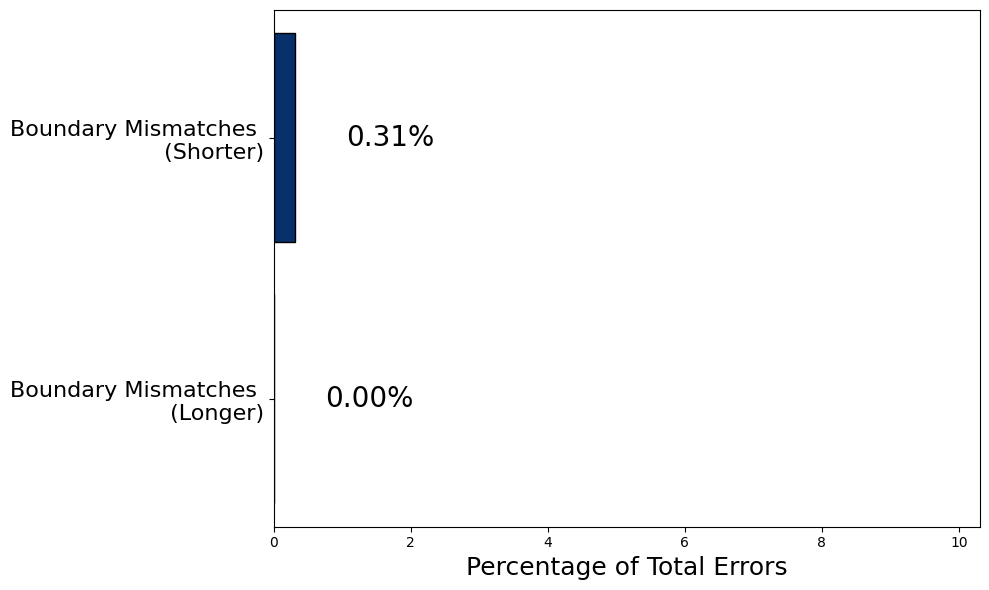

In [8]:
def process_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    blocks = content.split("\n\n")

    true_outputs = []
    predicted_outputs = []

    for block in blocks:
        if block.startswith("True Output:"):
            true_outputs.append(block[len("True Output:"):].strip())
        elif block.startswith("Predicted Output:"):
            predicted_outputs.append(block[len("Predicted Output:"):].strip())
        
    all_bracket_mismatches_longer = []
    all_bracket_mismatches_shorter = []
    all_true_outputs = []
    total_true_pred_output = 0
    total_true_matches = 0

    for true_output, predicted_output in zip(true_outputs, predicted_outputs):
        true_pred_output, bracket_mismatches_longer, bracket_mismatches_shorter = compare_outputs(true_output, predicted_output)

        total_true_pred_output += true_pred_output
        true_matches = parse_output(true_output)
        total_true_matches += len(true_matches)
    
        all_bracket_mismatches_longer.extend(bracket_mismatches_longer)
        all_bracket_mismatches_shorter.extend(bracket_mismatches_shorter)
    
    all_true_outputs.extend(true_outputs)

    
    count_and_plot_errors(
        all_bracket_mismatches_longer,
        all_bracket_mismatches_shorter,
        all_true_outputs
    )

    save_errors_to_files(
        all_bracket_mismatches_longer,
        all_bracket_mismatches_shorter,
    )
    if not true_outputs or not predicted_outputs:
        print("True Output or Predicted Output is missing in the file.")

process_file('/workspace/saradhi_pg/Nil/Work_3/Analysis/inference_texts/cdcp_flan-t5-base_inference.txt')
# print('glaucoma-inference-flan-t5-base.txt')
# process_file('glaucoma-inference-flan-t5-base.txt')
# print('mixed-inference-flan-t5-base.txt')
# process_file('mixed-inference-flan-t5-base.txt')
# print('combined-inference-flan-t5-base.txt')
# process_file('combined-inference-flan-t5-base.txt')